# Amazon Food Review Sentiment Analysis
## Classification Model via NLP

James Alikhani   
August 2017

The Amazon Fine Food Reviews dataset, from [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews), consists of 568,454 food reviews Amazon users left up to October 2012 is used in this calssification, natural language processing (NLP) practice to extract information from text reviews and apply it to train a predictive model. 
Each text review is labled from 1 to 5 by the user. The goal of this practice is to construct a predictive model to see an unlabeled recommendation is sentimentally positive or negative. This helps websites with an online review to extract information about their products to improve their businesses. 


In [158]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pylab as plt
%matplotlib inline

### Loading the data from SQLite file

In [4]:
# head of the dataset
con = sqlite3.connect('database.sqlite')
pd.read_sql_query('select * from Reviews limit 5', con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
# we only select the following attributes for our modeling purposes:
df = pd.read_sql_query("""
    SELECT Summary, Score
    FROM Reviews
""", con)

In [13]:
df.head()

,Summary,Score
0,Good Quality Dog Food,5
1,Not as Advertised,1
2,"""Delight"" says it all",4
3,Cough Medicine,2
4,Great taffy,5


In [14]:
print('Size of the data is {}'.format(df.shape))
print('Memory is {} Mb'.format(int(df.memory_usage(deep=False).sum()/1e6)))

Size of the data is (568454, 2)
Memory is 9 Mb


In [18]:
# Scores 1 and 2 are considered as negative sentiment and the rest as positive. 
df['Sentiment'] = df['Score'].apply(lambda score: 1 if score >3 else -1)

In [34]:
df.head()

,Summary,Score,Sentiment
0,Good Quality Dog Food,5,1
1,Not as Advertised,1,-1
2,"""Delight"" says it all",4,1
3,Cough Medicine,2,-1
4,Great taffy,5,1


## The feature extraction: 
### The Bag of Words representation

In [85]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from collections import defaultdict
import re
import string

In [151]:
# removing special and numerical characters
def clean_sentences(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]', ' ', sentence)     
    return sentence
    
df['Clean_Summary'] = df['Summary'].apply(clean_sentences)

In [159]:
df.head()

,Summary,Score,Sentiment,Clean_Summary
0,Good Quality Dog Food,5,1,good quality dog food
1,Not as Advertised,1,-1,not as advertised
2,"""Delight"" says it all",4,1,delight says it all
3,Cough Medicine,2,-1,cough medicine
4,Great taffy,5,1,great taffy


## WordClouds

In [149]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [155]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

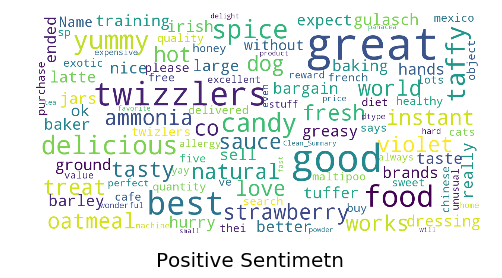

In [156]:
# Positive Sentiments:
show_wordcloud(df[df.Sentiment == 1]['Clean_Summary'], title = "Positive Sentimetn")

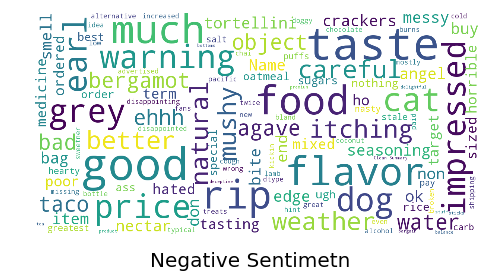

In [157]:
# Negative Sentiments:
show_wordcloud(df[df.Sentiment == -1]['Clean_Summary'], title = "Negative Sentimetn")

## Word Tokenizing
We create and save the vocabulary (lexicon) from the training set and use it later for the test set. (It's important not to use the all data together to create the tf_idf matrix and then split the tf_idf matrix to the test and train). 

In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X = df.Clean_Summary
y = df.Sentiment

seed = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [203]:
# Investigating the balance status of the data
y[y==1].sum()/len(y) * 100

78.067354614445492

Dataset is heavily unbalanced. 

In [217]:
# vectorizing the cleaned summary attribute
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.95, min_df=10)                 

In [218]:
X_train_vect = vectorizer.fit_transform(X_train)

In [219]:
X_train_vect.shape

(454763, 21397)

In [220]:
vectorizer.get_feature_names()[:10]

['aa',
 'abbey',
 'abby',
 'abc',
 'able',
 'able eat',
 'absolute',
 'absolute best',
 'absolute best herbal',
 'absolute favorite']

In [221]:
vectorizer.idf_

array([ 11.25494516,  11.38847655,  11.38847655, ...,  10.93649143,
        11.19432054,  11.62963861])

Let's check out the tokenized words lemmatizing effect in the word tokenizing:

In [170]:
from nltk import word_tokenize 
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
vectorizer_with_lemmatizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', 
                             ngram_range=(1, 3), max_df=0.9, min_df=100)                 

In [172]:
X_train_vect_lemmatized = vectorizer_with_lemmatizer.fit_transform(X_train)

In [173]:
X_train_vect_lemmatized.shape

(454763, 2100)

In [199]:
vectorizer_with_lemmatizer.get_feature_names()[:10]

['absolute',
 'absolute best',
 'absolutely',
 'absolutely best',
 'absolutely delicious',
 'absolutely love',
 'acid',
 'acidic',
 'acquired',
 'acquired taste']

Not that much of difference between lemmatized and regular tokenizer! We'll continue with the regular tokenizer due to its simplicity

In [222]:
# Vocabulary:
vocab = vectorizer.vocabulary_
len(vocab)

21397

In [223]:
vectorizer_testData = TfidfVectorizer(vocabulary=vocab)  

In [224]:
X_test_vect = vectorizer_testData.fit_transform(X_test)

In [225]:
X_test_vect.shape

(113691, 21397)

## Feature Selection 
Dimentionality reduction.

In [232]:
# we can use chi2 to calculate the amount of information each word (each column in the tf_idf matrix) carry 
# because tf_idf elements are all none_negative values
from sklearn.feature_selection import chi2, SelectKBest  
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [235]:
# number of features:
n_features = [10, 100, 500, 1000, 5000, 10000]
reducer_labels = ['KBest(chi2)']
bar_offsets = (np.arange(len(n_features)) *
               (len(reducer_labels) + 1) + .5)

pipeline_estimator = Pipeline([('dim_reduction', SelectKBest()), ('clf', LinearSVC(class_weight='balanced'))])

# param_grid : dict or list of dictionaries:
params = [{'dim_reduction': [SelectKBest(chi2)],
           'dim_reduction__k': n_features}]

grid = GridSearchCV(estimator=pipeline_estimator, param_grid=params, cv=3, n_jobs=-1)

grid.fit(X_train_vect, y_train)
mean_scores = np.array(grid.cv_results_['mean_test_score'])

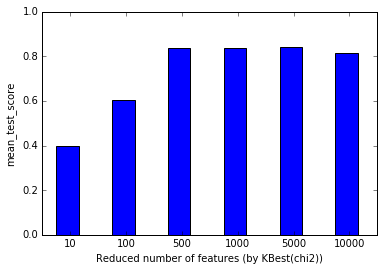

In [236]:
plt.figure()
plt.bar(bar_offsets, mean_scores, label='KBest(chi2)', color='b')

plt.xticks(bar_offsets + len(reducer_labels) / 2, n_features)
plt.xlabel('Reduced number of features (by KBest(chi2))')
plt.ylabel('mean_test_score')
plt.ylim((0, 1))
plt.show()


In [257]:
# It seems 500 is a proper number of dimensions
dim_reduction = SelectKBest(chi2, k=500)
dim_reduction.fit(X_train_vect, y_train)
X_train_reduced = dim_reduction.fit_transform(X_train_vect, y_train)
X_test_reduced = dim_reduction.fit_transform(X_test_vect, y_test)

In [258]:
X_test_reduced.shape

(113691, 500)

## Classification

In [246]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### with reduced sized data

-------------------------------------------------
Logistic Regression :
-------------------------------------------------
summary report: 
             precision    recall  f1-score   support

         -1       0.21      0.69      0.32     25044
          1       0.75      0.26      0.39     88647

avg / total       0.63      0.36      0.37    113691

roc_auc = 0.512
 
confusion matrix: 
[[17344  7700]
 [65339 23308]]

    
    
-------------------------------------------------
Bernoulli Naïve Bayes :
-------------------------------------------------
summary report: 
             precision    recall  f1-score   support

         -1       0.21      0.68      0.32     25044
          1       0.75      0.27      0.39     88647

avg / total       0.63      0.36      0.38    113691

roc_auc = 0.509
 
confusion matrix: 
[[16935  8109]
 [64898 23749]]

    
    
-------------------------------------------------
MultinomialNB :
-------------------------------------------------
summary report: 

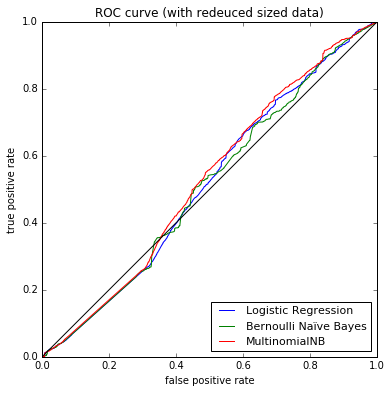

In [262]:
clfs_name = ['Logistic Regression', 'Bernoulli Naïve Bayes', 'MultinomialNB']

clfs = [LogisticRegression(class_weight='balanced'),
        BernoulliNB(),
        MultinomialNB()]

for i in range(3):
    clf = clfs[i]
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    y_score = clf.predict_proba(X_test_reduced)[:,1]
        
    print("-------------------------------------------------")
    print(clfs_name[i], ":")
    print("-------------------------------------------------")
    print("summary report: ")
    print(metrics.classification_report(y_test, y_pred))
       
    print("roc_auc = {:0.3f}".format(metrics.roc_auc_score(y_test, y_score)))
    
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(' ')
    print("confusion matrix: ")
    print(conf_mat)
    print("""
    
    """)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

    plt.figure(1, figsize=(6,6))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve (with redeuced sized data)')
    plt.plot(fpr, tpr, label = clfs_name[i] )
    plt.legend(loc=4, prop={'size':11})

plt.plot([0,1],[0,1], color = 'black')

The result is very bad. ROC area is almost 0.5 means the classification algorithm wasn't able to predict even better than
flip a coin :p

### with actual sized X

-------------------------------------------------
Logistic Regression :
-------------------------------------------------
summary report: 
             precision    recall  f1-score   support

         -1       0.50      0.82      0.62     25044
          1       0.94      0.76      0.84     88647

avg / total       0.84      0.78      0.79    113691

roc_auc = 0.883
 
confusion matrix: 
[[20653  4391]
 [20969 67678]]

    
    
-------------------------------------------------
Bernoulli Naïve Bayes :
-------------------------------------------------
summary report: 
             precision    recall  f1-score   support

         -1       0.72      0.59      0.64     25044
          1       0.89      0.94      0.91     88647

avg / total       0.85      0.86      0.85    113691

roc_auc = 0.888
 
confusion matrix: 
[[14663 10381]
 [ 5762 82885]]

    
    
-------------------------------------------------
MultinomialNB :
-------------------------------------------------
summary report: 

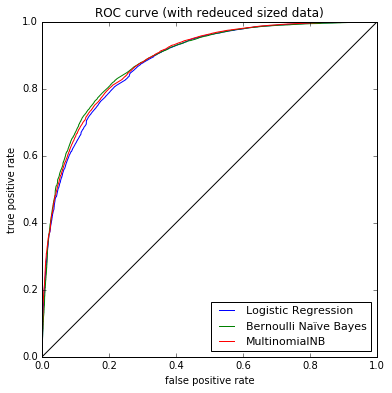

In [264]:
for i in range(3):
    clf = clfs[i]
    clf.fit(X_train_vect, y_train)
    y_pred = clf.predict(X_test_vect)
    y_score = clf.predict_proba(X_test_vect)[:,1]
        
    print("-------------------------------------------------")
    print(clfs_name[i], ":")
    print("-------------------------------------------------")
    print("summary report: ")
    print(metrics.classification_report(y_test, y_pred))
       
    print("roc_auc = {:0.3f}".format(metrics.roc_auc_score(y_test, y_score)))
    
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(' ')
    print("confusion matrix: ")
    print(conf_mat)
    print("""
    
    """)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

    plt.figure(1, figsize=(6,6))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve (with redeuced sized data)')
    plt.plot(fpr, tpr, label = clfs_name[i] )
    plt.legend(loc=4, prop={'size':11})

plt.plot([0,1],[0,1], color = 'black')

Wow, much better results. ROC curve close to 89% is reasonably high for a sentiment analysis classification. 